# FINAL DRAFT OF THIS 
Inputs: cdom files 
outputs: wavelenths.csv, plot.png, outputs.csv
    
    redesinge from inputs 
    
    Hanna Bridgham 
    last edited 11/17/2022

## PART 1: QA/QC

Loading data and checking for issues 

In [1]:
#LOAD REQUIERD PACKAGES 
import os # OS library
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names

from scipy.interpolate import PchipInterpolator # Interpolator
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [2]:
files = glob.glob('../Dissertation_projects/Experiments/MIXING_EXPS/GOM_St.9/*Abs*.txt')
pathlength = .50
psu = 1
ylimmin = -1
ylimmax = 2
files.sort()
print('I have your files')
files

I have your files


['../Dissertation_projects/Experiments/MIXING_EXPS/GOM_St.9\\50%_mix_time_series_Absorbance__0__70.txt',
 '../Dissertation_projects/Experiments/MIXING_EXPS/GOM_St.9\\50%_mix_time_series_Absorbance__10__80.txt',
 '../Dissertation_projects/Experiments/MIXING_EXPS/GOM_St.9\\50%_mix_time_series_Absorbance__11__81.txt',
 '../Dissertation_projects/Experiments/MIXING_EXPS/GOM_St.9\\50%_mix_time_series_Absorbance__12__82.txt',
 '../Dissertation_projects/Experiments/MIXING_EXPS/GOM_St.9\\50%_mix_time_series_Absorbance__13__83.txt',
 '../Dissertation_projects/Experiments/MIXING_EXPS/GOM_St.9\\50%_mix_time_series_Absorbance__14__84.txt',
 '../Dissertation_projects/Experiments/MIXING_EXPS/GOM_St.9\\50%_mix_time_series_Absorbance__15__85.txt',
 '../Dissertation_projects/Experiments/MIXING_EXPS/GOM_St.9\\50%_mix_time_series_Absorbance__16__86.txt',
 '../Dissertation_projects/Experiments/MIXING_EXPS/GOM_St.9\\50%_mix_time_series_Absorbance__17__87.txt',
 '../Dissertation_projects/Experiments/MIXING_E

In [3]:
# REMOVE THIS CELL ONE YOU GET IT
ID = os.path.basename(files[-1])[:-4].split("_")
ID

['PW', 'rhz', 'st', '9', 'P2F', 'Absorbance', '', '2', '', '69']

In [4]:
#LOAD FILE
def open_files(name):
    # reads individual scan files
    df = pd.read_table(name, skiprows=16,names=['wl', 'abs'], index_col='wl')
    # extract ID from filename
    ID = os.path.basename(name)[:-4].split("_")
    ID = '_'.join(list(filter(None, ID)))
    # rename col name with ID
    df = df.rename(columns={'abs': ID})
    return df

#LOOP TRU FILES TO MAKE ONE EASY TO USE DATA FRAME 
#columns are scanns and rows are wavelths 

frames = [open_files(f) for f in files]
df = pd.concat(frames, axis=1) # joins along cols  

print("files loaded :)")

files loaded :)


In [5]:
# TEST CODE 

df_noCorr = df 
df

,50%_mix_time_series_Absorbance_0_70,50%_mix_time_series_Absorbance_10_80,50%_mix_time_series_Absorbance_11_81,50%_mix_time_series_Absorbance_12_82,50%_mix_time_series_Absorbance_13_83,50%_mix_time_series_Absorbance_14_84,50%_mix_time_series_Absorbance_15_85,50%_mix_time_series_Absorbance_16_86,50%_mix_time_series_Absorbance_17_87,50%_mix_time_series_Absorbance_18_88,...,BBL_st_14.5_P2F_Absorbance_3_43,BBL_st_14.5_P2F_Absorbance_4_44,BBL_st_14.5_P2F_Absorbance_5_45,BBL_st_14.5_P2F_Absorbance_6_46,BBL_st_14.5_P2F_Absorbance_7_47,BBL_st_14.5_P2F_Absorbance_8_48,BBL_st_14.5_P2F_Absorbance_9_49,PW_rhz_st_9_P2F_Absorbance_0_67,PW_rhz_st_9_P2F_Absorbance_1_68,PW_rhz_st_9_P2F_Absorbance_2_69
wl,,,,,,,,,,,,,,,,,,,,,
190.0441,-0.0267,-0.0323,-0.0350,-0.0190,-0.0305,-0.0265,-0.0311,-0.0459,0.0039,-0.0247,...,0.0124,-0.0102,0.0122,0.0173,-0.0186,-0.0006,-0.0014,-0.0451,-0.0086,0.0058
190.4264,-0.0590,-0.0585,-0.0652,-0.0597,-0.0682,-0.0429,-0.0610,-0.0547,-0.0563,-0.0247,...,-0.0163,-0.0439,-0.0175,-0.0135,-0.0189,-0.0189,-0.0065,-0.0390,-0.0394,-0.0615
190.8087,-0.0440,-0.0613,-0.0779,-0.0767,-0.0811,-0.0685,-0.0651,-0.0669,-0.0819,-0.0595,...,-0.0354,-0.0274,-0.0237,-0.0228,-0.0375,-0.0304,-0.0270,-0.0434,-0.0623,-0.0706
191.1909,-0.0624,-0.0473,-0.0515,-0.0428,-0.0482,-0.0434,-0.0305,-0.0313,-0.0413,-0.0572,...,-0.0128,-0.0241,-0.0076,-0.0241,-0.0233,-0.0150,0.0100,-0.0432,-0.0423,-0.0303
191.5730,-0.0080,0.0185,-0.0225,-0.0374,-0.0143,-0.0221,-0.0115,-0.0268,-0.0157,-0.0369,...,-0.0017,0.0242,0.0118,0.0161,0.0353,0.0061,0.0387,0.0054,-0.0207,-0.0135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880.5978,-0.1014,-0.0450,-0.0405,-0.0439,-0.0443,-0.0259,-0.0245,-0.0136,-0.0323,-0.0300,...,0.0020,0.0194,0.0110,0.0233,0.0458,-0.0076,0.0680,-0.0443,-0.0387,-0.0418
880.8884,-0.1036,-0.0470,-0.0614,-0.0832,-0.0487,-0.0693,-0.0714,-0.0795,-0.0804,-0.0848,...,-0.0018,-0.0114,-0.0361,0.0123,-0.0190,-0.0140,-0.0124,-0.0811,-0.0657,-0.0610
881.1790,-0.1622,-0.1080,-0.0956,-0.0796,-0.0914,-0.1003,-0.0933,-0.1032,-0.0820,-0.0975,...,-0.0103,-0.0639,-0.0145,-0.0621,-0.0320,-0.1093,-0.0473,-0.0629,-0.0750,-0.0654


# define functions to be applied based on header info
def edark_fun(df, integration_time, scans_to_average):
    electric_dark_spectrum = (1 / integration_time) * (1 / scans_to_average)
    raw_spectrum = df
    corrected_spectrum = raw_spectrum - electric_dark_spectrum
    df = corrected_spectrum
    return df

def lin_cor_FLMS12623(df):
    # perform nonlinearity correction for spectrometer FLMS12623
    return df

def lin_cor_FLMS02459(df):
    # perform nonlinearity correction for spectrometer FLMS02459
    return df

#do the thing 

# initialize variables
spectrometer = None
edark = False
non_lin = False

# loop through files and apply functions based on header info
def open_files_corr(name):
    # reads individual scan files
    with open(name, 'r') as f:
        # read header
        header = f.read().splitlines()[:14]
        # extract integration time and scans to average
        integration_time = float(header[6].split(': ')[1])
        scans_to_average = int(header[7].split(': ')[1])
        # extract ID from filename
        ID = os.path.basename(name)[:-4].split("_")
        ID.pop(1)
        ID = '_'.join(list(filter(None, ID)))
        # read data
        df = pd.read_table(name, skiprows=14, names=['wl', 'abs'], index_col='wl')
        # apply electric dark correction
        if 'false' in header[8].split(': ')[1].lower():
            df = edark_fun(df, integration_time, scans_to_average)
        # apply linearity correction
        if 'false' in header[9].split(': ')[1].lower():
            if 'FLMS12623' in header[4].split(': ')[1]:
                df = lin_cor_FLMS12623(df)
            elif 'FLMS02459' in header[4].split(': ')[1]:
                df = lin_cor_FLMS02459(df)
        # rename col name with ID
        df = df.rename(columns={'abs': ID})
        return df
    
# concatenate frames into one data frame

frames = [open_files_corr(f) for f in files]
df = pd.concat(frames, axis=1) # joins along cols  

df

graph showing the cdom Absortion data


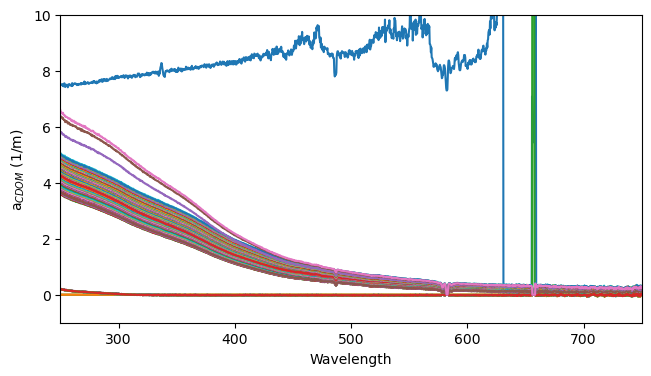

In [6]:
#Absorbance to Absortion
df_clean = df
df_cl = df_clean*(2.303/pathlength) # to avoid overwriting when reruning the cell
df_cl

#make a plot to make sure nothing is too crazy 

fig, ax = plt.subplots(figsize=(7.5,4))
df_cl.plot(ax=ax, legend=None)
ax.set_ylim(ylimmin,10)
ax.set_xlim(250,750)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
print('graph showing the cdom Absortion data')

### Salinity correction

the interproated data set for each scan is created
the mean data set for each sample is created
the transpose data set is created


C:\Users\hmlbr\AppData\Local\Temp\ipykernel_28868\573799340.py:25: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_mean = df_final.groupby(names, axis=1).mean()


see the graphs


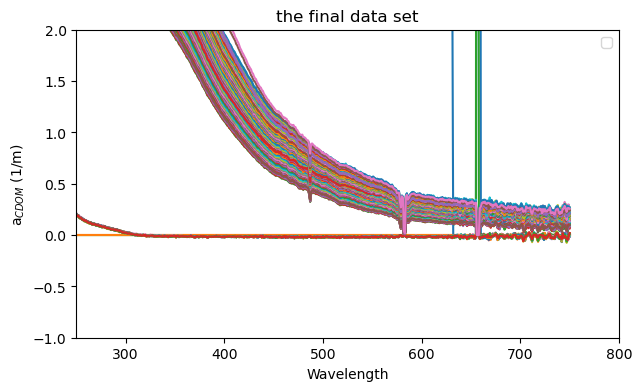

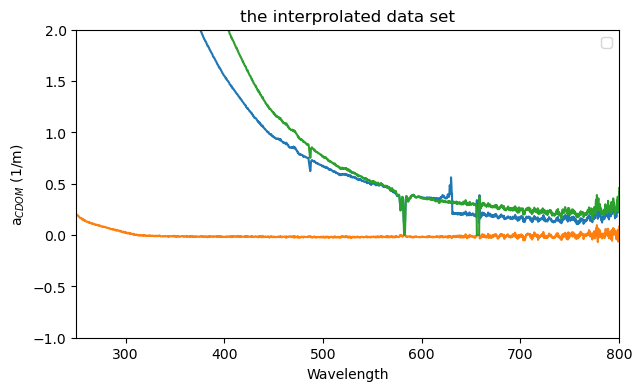

In [7]:
#HERE WE MAKE A COPY INTERPROLATED DATA SET
df_final = df_cl
x = df_final.index
coln = np.arange(0, len(df_final.columns), 1, dtype=int)

Frames = []
frames = []

for col in coln:
    y = df_final.iloc[:,col]
    pchip_col = PchipInterpolator(x, y, axis=1)
    xi = np.arange(250,751,1)
    yi = pchip_col(xi)
    d = {'abs': yi}
    pchip_c = pd.DataFrame(d, index = xi)
    Frames.append(pchip_c)

df_pchip = pd.concat(Frames, axis=1, ignore_index=False)
New_Labels = df_final.columns
df_pchip.columns = New_Labels
print("the interproated data set for each scan is created")

#HERE WE MAKE A MEAN DATA SET FOR EACH SAMPLE
names = [name[0] for name in df_pchip.columns.str.rsplit('_')]
df_mean = df_final.groupby(names, axis=1).mean()
df_mean
print("the mean data set for each sample is created")

#HERE WE MAKE A COPY OF THE DATA THAT IS VERTICAL SO JB LIKES IT
abs_data = df_mean.transpose(copy=False)
print("the transpose data set is created")

fig, ax = plt.subplots(figsize=(7,4))
df_pchip.plot(label='', ax=ax)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("the final data set")
ax.legend("")

fig, ax = plt.subplots(figsize=(7,4))
df_mean.plot(label='', ax=ax)
ax.set_ylim(ylimmin,ylimmax)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("the interprolated data set")
ax.legend("")

print("see the graphs")

In [8]:
df_final = df_cl.T
df_final.to_csv('../Dissertation_projects/Experiments/MIXING_EXPS/GOM_St.9.csv')